In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from offroad.utils import load_state
import json
import ipywidgets as widgets
from ipywidgets import interact
from car_dynamics.models_torch import MLP
from car_dynamics.envs import make_env, KinematicBicycleModel, KinematicParams, DynamicBicycleModel, DynamicParams
from car_dynamics.controllers_torch import MPPIController, rollout_fn_select, reward_track_fn
import matplotlib.colors as colors
from car_dynamics.models_torch import MLP, parse_data_end2end_norm 

%matplotlib inline
%load_ext autoreload
%autoreload 2

PROJ_DIR = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/'
SPEED = 1.0
LF = .16
LR = .15
L = LF+LR
N_ROLLOUTS = 10000
H = 4
DT = 0.05
SIGMA = 1.0

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# log_dir = os.path.join(PROJ_DIR, 'data', 'data-20240131-195144') # drag
log_dir = os.path.join(PROJ_DIR, 'data', 'data-20240229-114933') # counter 
# log_dir = os.path.join(PROJ_DIR, 'data', 'data-20240205-000620') # circle
# log_dir = os.path.join(PROJ_DIR, 'data', 'sim-data-20240131-134617')
with open(os.path.join(log_dir, 'header.json')) as f:
    header_info = json.load(f)
# t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0, 144], orientation_provider="ORIENTATION_PROVIDOER")
t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [10, 81], orientation_provider="ORIENTATION_PROVIDOER")
# t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0, 303], orientation_provider="ORIENTATION_PROVIDOER")
# t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0, 1], orientation_provider="ORIENTATION_PROVIDOER")
obs_np = p_dict['obs']
obs_np_1 = obs_np + .0
targets = controller_info['targets']
# targets = np.array([target[0] for target in controller_info['targets']])
is_recover = controller_info['is_recover']

## Dynamic Bicycle Model

In [17]:
model_params = DynamicParams(
                    num_envs=N_ROLLOUTS,
                    DT=DT,
)   


dynamics = DynamicBicycleModel(model_params, device=DEVICE)
rollout_fn = rollout_fn_select('dbm', dynamics, DT, L, LR)
dynamics.reset()

def rollout_start_kbm():
    dynamics.reset()

sigmas = torch.tensor([SIGMA] * 2)
a_cov_per_step = torch.diag(sigmas**2)
a_cov_init = a_cov_per_step.unsqueeze(0).repeat(H, 1, 1)
# a_cov_prev =  torch.full((H, 2, 2), 3.0**2) * torch.eye(2).unsqueeze(0).repeat(H, 1, 1)

# import pdb; pdb.set_trace()

mppi = MPPIController(
    gamma_mean=1.0,
    gamma_sigma=0.0,
    discount=1.0,
    sample_sigma = 0.5,
    lam = 0.01,
    a_mean=torch.zeros(H, 2, device=DEVICE),
    a_cov = a_cov_init.to(DEVICE),
    n_rollouts=N_ROLLOUTS,
    H=H,
    device=DEVICE,
    rollout_fn=rollout_fn,
    a_min = [-1., -1],
    a_max = [1., 1.],
    a_mag = [.25, 1.],
    a_shift= [0.25, 0.],
    delay=0,
    len_history=3,
    rollout_start_fn=rollout_start_kbm,
    debug=False,
    fix_history=False
)

def plot(N=570):
    target_N = np.array(targets[N])
    for i in range(N):
        mppi.feed_hist(obs_np[i, :4], torch.tensor(action_list[i, :2], device=DEVICE))

    target_pos_tensor = torch.Tensor(targets[N]).to(DEVICE).squeeze(dim=-1)
    action, mppi_info = mppi(obs_tensor[N, :4], reward_track_fn(target_pos_tensor, SPEED), vis_all_traj=True, vis_optim_traj=True)
    all_traj = mppi_info['all_trajectory']
    optim_traj = mppi_info['trajectory']
    # plt.plot(obs_np[max(0,N-20):, 0], obs_np[max(0,N-20):, 1], alpha=0.5)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(obs_np[:, 0], obs_np[:, 1], alpha=0.5)
    for i in range(H+1):
        axs[0].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2)
    axs[0].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o')
    for i in range(H+1):
        axs[1].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2,)
    axs[1].plot(target_N[:, 0], target_N[:, 1], 'pink', marker='^', label='reference')
    axs[1].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', label='optim traj')
    axs[1].plot(obs_np[N:N+H, 0], obs_np[N:N+H, 1], alpha=1, marker='x', color='black', label='real traj')
    axs[1].set_aspect('equal')
    axs[0].set_aspect('equal')
    axs[1].legend()
    
    plt.suptitle("mppi-KBM")
interact(
    plot,
    N=(0, len(obs_np))
)


interactive(children=(IntSlider(value=570, description='N', max=3030), Output()), _dom_classes=('widget-intera…

<function __main__.plot(N=570)>

In [18]:
len_history = 8
model_dir = os.path.join(PROJ_DIR, 'tmp', '20240131-155022', 'model.pt')
dynamics_nn = MLP(input_size=7*len_history, hidden_size=32, output_size=5)
dynamics_nn.load(model_dir)
dynamics_nn.to(DEVICE)
rollout_fn = rollout_fn_select('nn-end2end', dynamics_nn, DT, L, LR)

def rollout_start_nn():
    ...

sigmas = torch.tensor([SIGMA] * 2)
a_cov_per_step = torch.diag(sigmas**2)
a_cov_init = a_cov_per_step.unsqueeze(0).repeat(H, 1, 1)
# a_cov_prev =  torch.full((H, 2, 2), 3.0**2) * torch.eye(2).unsqueeze(0).repeat(H, 1, 1)

# import pdb; pdb.set_trace()

mppi = MPPIController(
    gamma_mean=1.0,
    gamma_sigma=0.0,
    discount=1.0,
    sample_sigma = 0.5,
    lam = 0.01,
    a_mean=torch.zeros(H, 2, device=DEVICE),
    a_cov = a_cov_init.to(DEVICE),
    n_rollouts=N_ROLLOUTS,
    H=H,
    device=DEVICE,
    rollout_fn=rollout_fn,
    a_min = [-1., -1],
    a_max = [1., 1.],
    a_mag = [.05, 1.],
    a_shift= [0.15, 0.],
    delay=0,
    len_history=len_history,
    rollout_start_fn=rollout_start_nn,
)

def plot(N=300):
    target_N = np.array(targets[N])
    for i in range(N):
        mppi.feed_hist(obs_np[i, :4], torch.tensor(action_list[i, :2], device=DEVICE))

    target_pos_tensor = torch.Tensor(targets[N]).to(DEVICE).squeeze(dim=-1)
    action, mppi_info = mppi(obs_np[N, :4], reward_track_fn(target_pos_tensor, SPEED), vis_all_traj=True, vis_optim_traj=True, use_nn=True)
    all_traj = mppi_info['all_trajectory']
    optim_traj = mppi_info['trajectory']
    all_actions = mppi_info['action_candidate']
    # plt.plot(obs_np[max(0,N-20):, 0], obs_np[max(0,N-20):, 1], alpha=0.5)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(obs_np[:, 0], obs_np[:, 1], alpha=0.5)
    for i in range(H+1):
        axs[0].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2)
    axs[0].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', )
    axs[0].set_aspect('equal')
    
    for i in range(H+1):
        axs[1].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2,)
    axs[1].plot(target_N[:, 0], target_N[:, 1], 'pink', marker='^', label='reference')
    axs[1].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', label='optim traj')
    axs[1].plot(obs_np[N:N+H, 0], obs_np[N:N+H, 1], alpha=1, marker='x', color='black', label='real traj')
    axs[1].set_aspect('equal')
    h = axs[2].hist2d(all_actions[:, 0,0], all_actions[:, 0, 1],norm=colors.LogNorm(), bins=50)
    fig.colorbar(h[3], ax=axs[2])
    plt.suptitle("mppi-NN (Real)")
    plt.tight_layout()
interact(
    plot,
    N=(555, 580, 1)
)


KeyError: 'state_dict'

In [115]:
len_history = 8
model_dir = os.path.join(PROJ_DIR, 'tmp', '20240131-165751', 'model.pt')
dynamics_nn = MLP(input_size=7*len_history, hidden_size=32, output_size=5)
dynamics_nn.load(model_dir)
dynamics_nn.to(DEVICE)
rollout_fn = rollout_fn_select('nn-end2end', dynamics_nn, DT, L, LR)

def rollout_start_nn():
    ...

sigmas = torch.tensor([SIGMA] * 2)
a_cov_per_step = torch.diag(sigmas**2)
a_cov_init = a_cov_per_step.unsqueeze(0).repeat(H, 1, 1)
# a_cov_prev =  torch.full((H, 2, 2), 3.0**2) * torch.eye(2).unsqueeze(0).repeat(H, 1, 1)

# import pdb; pdb.set_trace()

mppi = MPPIController(
    gamma_mean=1.0,
    gamma_sigma=0.0,
    discount=1.0,
    sample_sigma = 0.5,
    lam = 0.01,
    a_mean=torch.zeros(H, 2, device=DEVICE),
    a_cov = a_cov_init.to(DEVICE),
    n_rollouts=N_ROLLOUTS,
    H=H,
    device=DEVICE,
    rollout_fn=rollout_fn,
    a_min = [-1., -1],
    a_max = [1., 1.],
    a_mag = [.25, 1.],
    a_shift= [0.25, 0.],
    delay=0,
    len_history=len_history,
    rollout_start_fn=rollout_start_nn,
)

def plot(N=300):
    target_N = np.array(targets[N])
    for i in range(N):
        mppi.feed_hist(obs_np[i, :4], torch.tensor(action_list[i, :2], device=DEVICE))

    target_pos_tensor = torch.Tensor(targets[N]).to(DEVICE).squeeze(dim=-1)
    action, mppi_info = mppi(obs_np[N, :4], reward_track_fn(target_pos_tensor, SPEED), vis_all_traj=True, vis_optim_traj=True, use_nn=True)
    all_traj = mppi_info['all_trajectory']
    optim_traj = mppi_info['trajectory']
    all_actions = mppi_info['action_candidate']
    # plt.plot(obs_np[max(0,N-20):, 0], obs_np[max(0,N-20):, 1], alpha=0.5)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(obs_np[:, 0], obs_np[:, 1], alpha=0.5)
    for i in range(H+1):
        axs[0].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2)
    axs[0].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', )
    axs[0].set_aspect('equal')
    
    for i in range(H+1):
        axs[1].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2,)
    axs[1].plot(target_N[:, 0], target_N[:, 1], 'pink', marker='^', label='reference')
    axs[1].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', label='optim traj')
    axs[1].plot(obs_np[N:N+H, 0], obs_np[N:N+H, 1], alpha=1, marker='x', color='black', label='real traj')
    axs[1].set_aspect('equal')
    axs[1].legend()
    # axs[2].hist2d(all_actions[:, 0,0], all_actions[:, 0, 1],norm=colors.LogNorm())
    plt.suptitle("mppi-NN (Mix 1:1)")
    plt.tight_layout()
interact(
    plot,
    N=(0, len(obs_np))
)


TypeError: __init__() missing 2 required positional arguments: 'debug' and 'fix_history'

In [116]:
len_history = 2
model_dir = os.path.join(PROJ_DIR, 'tmp', '20240201-182437', 'model.pt')
dynamics_nn = MLP(input_size=7*len_history, hidden_size=64, output_size=5)
dynamics_nn.load(model_dir)
dynamics_nn.to(DEVICE)
rollout_fn = rollout_fn_select('nn-end2end', dynamics_nn, DT, L, LR)

def rollout_start_nn():
    ...

sigmas = torch.tensor([SIGMA] * 2)
a_cov_per_step = torch.diag(sigmas**2)
a_cov_init = a_cov_per_step.unsqueeze(0).repeat(H, 1, 1)
# a_cov_prev =  torch.full((H, 2, 2), 3.0**2) * torch.eye(2).unsqueeze(0).repeat(H, 1, 1)

# import pdb; pdb.set_trace()

mppi = MPPIController(
    gamma_mean=1.0,
    gamma_sigma=0.0,
    discount=1.0,
    sample_sigma = 0.5,
    lam = 0.01,
    a_mean=torch.zeros(H, 2, device=DEVICE),
    a_cov = a_cov_init.to(DEVICE),
    n_rollouts=N_ROLLOUTS,
    H=H,
    device=DEVICE,
    rollout_fn=rollout_fn,
    a_min = [-1., -1],
    a_max = [1., 1.],
    a_mag = [.25, 1.],
    a_shift= [0.25, 0.],
    delay=0,
    len_history=len_history,
    rollout_start_fn=rollout_start_nn,
)

def plot(N=300):
    target_N = np.array(targets[N])
    for i in range(N):
        mppi.feed_hist(obs_np[i, :4], torch.tensor(action_list[i, :2], device=DEVICE))

    target_pos_tensor = torch.Tensor(targets[N]).to(DEVICE).squeeze(dim=-1)
    action, mppi_info = mppi(obs_np[N, :4], reward_track_fn(target_pos_tensor, SPEED), vis_all_traj=True, vis_optim_traj=True, use_nn=True)
    all_traj = mppi_info['all_trajectory']
    optim_traj = mppi_info['trajectory']
    all_actions = mppi_info['action_candidate']
    # plt.plot(obs_np[max(0,N-20):, 0], obs_np[max(0,N-20):, 1], alpha=0.5)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(obs_np[:, 0], obs_np[:, 1], alpha=0.5)
    for i in range(H+1):
        axs[0].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2)
    axs[0].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', )
    axs[0].set_aspect('equal')
    
    for i in range(H+1):
        axs[1].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2,)
    axs[1].plot(target_N[:, 0], target_N[:, 1], 'pink', marker='^', label='reference')
    axs[1].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', label='optim traj')
    axs[1].plot(obs_np[N:N+H, 0], obs_np[N:N+H, 1], alpha=1, marker='x', color='black', label='real traj')
    axs[1].set_aspect('equal')
    axs[1].legend()
    axs[2].hist2d(all_actions[:, 0,0], all_actions[:, 0, 1],norm=colors.LogNorm())
    plt.suptitle("mppi-NN (Sim)")
    plt.tight_layout()
interact(
    plot,
    N=(0, len(obs_np))
)


RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for fc1.weight: copying a param with shape torch.Size([32, 56]) from checkpoint, the shape in current model is torch.Size([64, 14]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([5, 32]) from checkpoint, the shape in current model is torch.Size([5, 64]).

In [39]:
len_history = 3
model_params = DynamicParams(
                    num_envs=N_ROLLOUTS,
                    DT=DT,
                    Ta=10,
)   


dynamics = DynamicBicycleModel(model_params, device=DEVICE)
rollout_fn = rollout_fn_select('dbm', dynamics, DT, L, LR)

def rollout_start_nn():
    ...

SIGMA = 10.
sigmas = torch.tensor([SIGMA] * 2)
a_cov_per_step = torch.diag(sigmas**2)
a_cov_init = a_cov_per_step.unsqueeze(0).repeat(H, 1, 1)
# a_cov_prev =  torch.full((H, 2, 2), 3.0**2) * torch.eye(2).unsqueeze(0).repeat(H, 1, 1)

# import pdb; pdb.set_trace()

mppi = MPPIController(
    gamma_mean=1.0,
    gamma_sigma=0.0,
    discount=1.,
    sample_sigma = 0.5,
    lam = 0.01,
    a_mean=torch.zeros(H, 2, device=DEVICE),
    a_cov = a_cov_init.to(DEVICE),
    n_rollouts=N_ROLLOUTS,
    H=H,
    device=DEVICE,
    rollout_fn=rollout_fn,
    a_min = [-1., -1],
    a_max = [1., 1.],
    a_mag = [.075, 1.],
    a_shift= [0.127, 0.],
    delay=0,
    len_history=len_history,
    rollout_start_fn=rollout_start_nn,
    debug=False,
    fix_history=False,
    num_actions=2,
    num_obs=6,
)

def plot(N=570):
    target_N = np.array(targets[N])
    obs_tensor = torch.tensor(obs_np, device=DEVICE)
    v_vec = ( obs_tensor[1:, :2] - obs_tensor[:-1, :2] ) / DT
    vx = v_vec[:, 0] * torch.cos(obs_tensor[1:, 2]) + v_vec[:, 1] * torch.sin(obs_tensor[1:, 2])
    vy = v_vec[:, 1] * torch.cos(obs_tensor[1:, 2]) - v_vec[:, 0] * torch.sin(obs_tensor[1:, 2])
    omega = obs_tensor[1:,2] - obs_tensor[:-1,2]
    omega = torch.atan2(torch.sin(omega), torch.cos(omega)) / DT
    for i in range(1, N):
        obs_t = torch.tensor([obs_tensor[i,0], obs_tensor[i,1],obs_tensor[i,2],vx[i-1],vy[i-1],omega[i-1]], device=DEVICE)
        mppi.feed_hist(obs_t, torch.tensor(action_list[i, :2], device=DEVICE))


    target_pos_tensor = torch.Tensor(targets[N]).to(DEVICE).squeeze(dim=-1)
    obs_N = torch.tensor([obs_tensor[N,0], obs_tensor[N,1],obs_tensor[N,2],vx[N-1],vy[N-1],omega[N-1]], device=DEVICE)
    action, mppi_info = mppi(obs_N, reward_track_fn(target_pos_tensor, SPEED), vis_all_traj=True, vis_optim_traj=True, use_nn=True)
    all_traj = mppi_info['all_trajectory']
    optim_traj = mppi_info['trajectory']
    all_actions = mppi_info['action_candidate']
    # plt.plot(obs_np[max(0,N-20):, 0], obs_np[max(0,N-20):, 1], alpha=0.5)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(obs_np[:, 0], obs_np[:, 1], alpha=0.5)
    # print(all_traj)
    for i in range(H+1):
        axs[0].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2)
    axs[0].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', )
    axs[0].set_aspect('equal')
    
    for i in range(H+1):
        axs[1].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2,)
    axs[1].plot(target_N[:, 0], target_N[:, 1], 'pink', marker='^', label='reference')
    axs[1].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', label='optim traj')
    axs[1].plot(obs_np[N:N+H, 0], obs_np[N:N+H, 1], alpha=1, marker='x', color='black', label='real traj')
    axs[1].set_aspect('equal')
    axs[1].legend()
    # axs[2].hist2d(all_actions[:, 0,0], all_actions[:, 0, 1],norm=colors.LogNorm())
    plt.suptitle("mppi-DBM")
    plt.tight_layout()
interact(
    plot,
    N=(0, len(obs_np))
)


interactive(children=(IntSlider(value=570, description='N', max=710), Output()), _dom_classes=('widget-interac…

<function __main__.plot(N=570)>

In [37]:
all_traj

NameError: name 'all_traj' is not defined

## Evaluate

In [19]:
import numpy as np 
def sig(x):
 return 1/(1 + np.exp(-x))

In [35]:
len_history = 2
# model_dir = os.path.join(PROJ_DIR, 'tmp', '20240211-171037', 'model.pt')
model_dir = os.path.join(PROJ_DIR, 'tmp', '20240212-101637', 'model.pt')

# model_dir = os.path.join(PROJ_DIR, 'tmp', '20240131-142206', 'model.pt')
dynamics_nn = MLP(input_size=6*len_history, hidden_size=128, output_size=4)
dynamics_nn.load(model_dir)
dynamics_nn.to(DEVICE)
# rollout_fn = rollout_fn_select('nn-phyx-kbm', dynamics_nn, DT, L, LR)
rollout_fn = rollout_fn_select('nn-end2end', dynamics_nn, DT, L, LR)
# rollout_fn = rollout_fn_select('nn-end2end-trunk', dynamics_nn, DT, L, LR)

def rollout_start_nn():
    ...

sigmas = torch.tensor([SIGMA] * 2)
a_cov_per_step = torch.diag(sigmas**2)
a_cov_init = a_cov_per_step.unsqueeze(0).repeat(H, 1, 1)
# a_cov_prev =  torch.full((H, 2, 2), 3.0**2) * torch.eye(2).unsqueeze(0).repeat(H, 1, 1)

# import pdb; pdb.set_trace()

mppi = MPPIController(
    gamma_mean=1.0,
    gamma_sigma=0.0,
    discount=1,
    sample_sigma = 0.5,
    lam = 0.01,
    a_mean=torch.zeros(H, 2, device=DEVICE),
    a_cov = a_cov_init.to(DEVICE),
    n_rollouts=N_ROLLOUTS,
    H=H,
    device=DEVICE,
    rollout_fn=rollout_fn,
    a_min = [-1., -1],
    a_max = [1., 1.],
    a_mag = [.25, 1.],
    a_shift= [0.25, 0.],
    delay=0,
    len_history=len_history,
    rollout_start_fn=rollout_start_nn,
    debug=False,
    fix_history=False,
)

def plot(N=570, show_idx=0):
    target_N = np.array(targets[N])
    for i in range(N):
        mppi.feed_hist(obs_np[i, :4], torch.tensor(action_list[i, :2], device=DEVICE))

    target_pos_tensor = torch.Tensor(targets[N]).to(DEVICE).squeeze(dim=-1)
    action, mppi_info = mppi(obs_np[N, :4], reward_track_fn(target_pos_tensor, SPEED), vis_all_traj=True, vis_optim_traj=True, use_nn=True, nominal_actions = action_list[N:N+H+1, :2])
    print(len(mppi_info['x_all']))
    all_traj = mppi_info['all_trajectory']
    optim_traj = mppi_info['trajectory']
    all_actions = mppi_info['action_candidate']
    optim_action = mppi_info['action']
    
    # plt.plot(obs_np[max(0,N-20):, 0], obs_np[max(0,N-20):, 1], alpha=0.5)
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].plot(obs_np[:, 0], obs_np[:, 1], alpha=0.5)
    for i in range(H+1):
        axs[0].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2)
    axs[0].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', )
    axs[0].set_aspect('equal')
    
    for i in range(H+1):
        axs[1].scatter(all_traj[i][:, 0], all_traj[i][:, 1], s=1, alpha=0.2,)
    axs[1].plot(target_N[:, 0], target_N[:, 1], 'pink', marker='^', label='reference')
    axs[1].plot(optim_traj[:, 0], optim_traj[:, 1], 'cyan', marker='o', label='optim traj')
    axs[1].plot(obs_np[N:N+H+1, 0], obs_np[N:N+H+1, 1], alpha=1, marker='x', color='black', label='real traj')
    axs[1].set_aspect('equal')
    axs[1].legend()
    
    axs[2].scatter(optim_action[0][0], optim_action[0][1], marker='o', color='cyan', label='optim action')
    axs[2].scatter(action_list[N, 0], action_list[N, 1], marker='x', color='black', label='real action')
    axs[2].set_xlim([0,1])
    axs[2].set_ylim([-1,1])
    axs[2].legend()
    
    # axs[2].hist2d(all_actions[:, 0,0], all_actions[:, 0, 1],norm=colors.LogNorm())
    plt.suptitle("mppi-NN-phyx-kbm")
    plt.tight_layout()
interact(
    plot,
    N=(0, len(obs_np)),
    show_idx = [0,1,2,3],
)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/tmp/20240212-101637/model.pt'

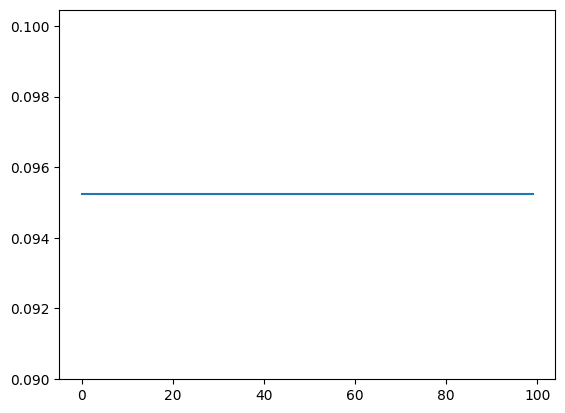

In [75]:
# mppi_info['x_all'][0][-2:] == mppi_info['x_all'][2][-2:]
y_all = np.array(mppi_info['y_all'])
plt.plot(y_all[:100, 1]**2)

In [32]:
from sklearn.preprocessing import StandardScaler
PROJ_DIR = '/home/wenli-run/car_collect'
log_dir = 'data/'
dt = 0.05
H = 4
train_data_list = [
#    dict(name='real-random', dir='data-20240201-200427', range=[5, 480]),
#    dict(name='real-random', dir='data-20240201-202035', range=[5, 489]),
#    dict(name='real-random', dir='data-20240201-221923', range=[5, 689]),
   dict(name='sim-random', dir='sim-data-20240131-134617', range=[0, 1]),
]
X_train, _ = parse_data_end2end_norm(H, train_data_list, load_state, PROJ_DIR, log_dir, dt)
X_test = torch.tensor(mppi_info['x_all'])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

def pca(data, n_components):
    # Centering the data (subtract the mean)
    mean = torch.mean(data, 0)
    data = data - mean.expand_as(data)

    # SVD
    U, S, V = torch.svd(torch.t(data))
    return torch.mm(data, U[:, :n_components])

# Apply PCA to both datasets (choose the number of components, e.g., 2)
n_components = 3
train_pca = pca(X_train_tensor, n_components)
test_pca = pca(X_test_tensor, n_components)

def plot(elev, azim):
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for training and testing data
    ax.scatter(train_pca[:, 0], train_pca[:, 1], train_pca[:, 2], label='Sim Data', alpha=0.5, s=1)
    ax.scatter(test_pca[:, 0], test_pca[:, 1], test_pca[:, 2], label='MPPI Data', alpha=0.1, s=1)

    # Labels and title
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    # elev = 30 # Elevation in degrees
    # azim = 45 # Azimuthal angle in degrees
    ax.view_init(elev=elev, azim=azim)
    plt.legend()
    plt.title('3D PCA of Training and Testing Datasets')
    plt.show()
interact(plot, elev=(-90, 90, 1), azim=(-180, 180, 1))

# # Labels and title
# plt.figure(figsize=(10, 6))
# plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Training Data', alpha=0.5, s=1)
# plt.scatter(test_pca[:, 0], test_pca[:, 1], label='Testing Data', alpha=0.5, s=1)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.title('PCA of Training and Testing Datasets')
# plt.show()

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90), IntSlider(value=0, description=…

<function __main__.plot(elev, azim)>